In [30]:
from music21 import *
import os #for listing down the file names
import numpy as np #Array Processing
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from keras.models import load_model
import random

## References:

## https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

## https://towardsdatascience.com/neural-networks-for-music-generation-97c983b50204

## https://github.com/gauravtheP/Music-Generation-Using-Deep-Learning


## Music 21 is a Python library developed by MIT for understanding music data. MIDI is a standard format for storing music files. MIDI stands for Musical Instrument Digital Interface. MIDI files contain the instructions rather than the actual audio. Hence, it occupies very little memory. That’s why it is usually preferred while transferring files.

## Reading Musical Files:

## The following function is used for reading the MIDI files. It returns the array of notes and chords present in the musical file.

In [3]:
#defining function to read MIDI files
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

## Reading the MIDI files from the specified path

In [12]:
#specify the path
path='classical/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

Loading Music File: classical/1812_overture-Tchaikovsky_rcg.mid
Loading Music File: classical/1812_overture_gr.mid
Loading Music File: classical/aeris_theme_mi2.mid
Loading Music File: classical/after_the_sunrise-Yanni_da4.mid
Loading Music File: classical/air_on_the_G_string-Bach_gp.mid
Loading Music File: classical/allerseelen-Strauss_rcg.mid
Loading Music File: classical/all_i_ask_of_you-Phantom-Opera_en.mid
Loading Music File: classical/american_salute-morton-gould_gp.mid
Loading Music File: classical/america_the_beautiful-Dragon_rcg.mid
Loading Music File: classical/an_american_in_paris_en.mid
Loading Music File: classical/aria-yanni-ac3.mid
Loading Music File: classical/bach_bouree_bk.mid
Loading Music File: classical/bach_english_suite3_inG-Allemande_david_siu.mid
Loading Music File: classical/batman-movie-theme_en.mid
Loading Music File: classical/belle_of_the_ball_gp.mid
Loading Music File: classical/bolero-Ravel_dw2.mid
Loading Music File: classical/brahms_lullaby_az.mid
Load

In [13]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

247


(array([245.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.0000e+00, 7.5380e+02, 1.5066e+03, 2.2594e+03, 3.0122e+03,
        3.7650e+03, 4.5178e+03, 5.2706e+03, 6.0234e+03, 6.7762e+03,
        7.5290e+03]),
 <a list of 10 Patch objects>)

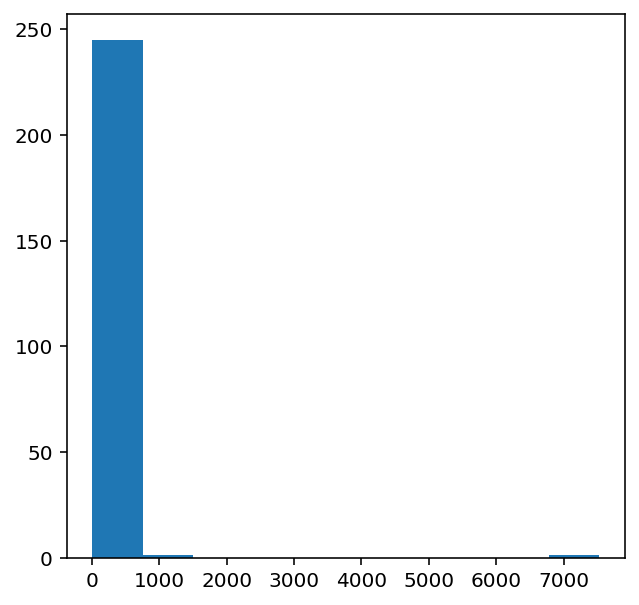

In [14]:
#importing library
from collections import Counter

#computing frequency of each note
freq = dict(Counter(notes_))

#library for visualiation
import matplotlib.pyplot as plt

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

In [16]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

## Preparing the input and output sequences 

In [17]:

no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [18]:
## Assigning a unique integer to every note:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [19]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [21]:
#Preparing the integer sequence for output data

In [22]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

## 80% of the data for training and 20% for evaluation

In [23]:
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

In [25]:
#Model architecture is as follows:

In [24]:
def lstm():
  model = Sequential()
  model.add(LSTM(128,return_sequences=True))
  model.add(LSTM(128))
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dense(n_vocab))
  model.add(Activation('softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
  return model

In [26]:
K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
   
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 100)           24600     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 64)            19264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 128)           

In [27]:
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [29]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=20, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

Train on 16240 samples, validate on 4060 samples
Epoch 1/20
16240/16240 [==============================] - 13s 789us/step - loss: 1.8146 - val_loss: 1.9590

Epoch 00001: val_loss improved from 2.01152 to 1.95899, saving model to best_model.h5
Epoch 2/20
16240/16240 [==============================] - 13s 780us/step - loss: 1.7421 - val_loss: 1.9134

Epoch 00002: val_loss improved from 1.95899 to 1.91343, saving model to best_model.h5
Epoch 3/20
16240/16240 [==============================] - 14s 832us/step - loss: 1.6796 - val_loss: 1.8323

Epoch 00003: val_loss improved from 1.91343 to 1.83226, saving model to best_model.h5
Epoch 4/20
16240/16240 [==============================] - 13s 821us/step - loss: 1.6301 - val_loss: 1.8170

Epoch 00004: val_loss improved from 1.83226 to 1.81701, saving model to best_model.h5
Epoch 5/20
16240/16240 [==============================] - 13s 826us/step - loss: 1.5918 - val_loss: 1.8388

Epoch 00005: val_loss did not improve from 1.81701
Epoch 6/20
16240

In [31]:

model = load_model('best_model.h5')

c:\users\aneesh\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [40]:

ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(20):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    


In [41]:
## Converting the integers back into the notes

In [42]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

## The final step is to convert back the predictions into a MIDI file

In [43]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

In [44]:
convert_to_midi(predicted_notes)

## After converting from .mid to .mp3 let us hear one of the final pieces of generated music

In [3]:
import IPython
IPython.display.Audio("music.mp3")